# first model
## simle train and test data only  
## 5-FoldCV


In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls ../input

HomeCredit_columns_description.csv  bureau_balance.csv
POS_CASH_balance.csv		    credit_card_balance.csv
application_test.csv		    installments_payments.csv
application_train.csv		    previous_application.csv
bureau.csv			    sample_submission.csv


In [3]:
pd.options.display.max_columns = None

In [4]:
st = time.time()
train_df = pd.read_csv('../input/application_train.csv')
test_df = pd.read_csv('../input/application_test.csv')
time.time() - st

9.310597896575928

In [5]:
all_df = pd.concat([train_df, test_df])
n_train = len(train_df)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in all_df.columns if all_df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    all_df[col] = all_df[col].astype('str')
    le.fit(all_df[col])
    all_df[col] = le.transform(all_df[col])

train_df = all_df[:n_train]
test_df = all_df[n_train:].drop('TARGET', axis=1)

del all_df
gc.collect()

100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


14

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.751134	valid_1's auc: 0.735758
[200]	training's auc: 0.772364	valid_1's auc: 0.747989
[300]	training's auc: 0.786335	valid_1's auc: 0.752378
[400]	training's auc: 0.797659	valid_1's auc: 0.754156
[500]	training's auc: 0.807581	valid_1's auc: 0.754974
[600]	training's auc: 0.816899	valid_1's auc: 0.755433
[700]	training's auc: 0.825541	valid_1's auc: 0.755923
[800]	training's auc: 0.833395	valid_1's auc: 0.756042
[900]	training's auc: 0.840997	valid_1's auc: 0.756345
Early stopping, best iteration is:
[897]	training's auc: 0.840787	valid_1's auc: 0.756378
Fold  1 AUC : 0.756378
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.750531	valid_1's auc: 0.74429
[200]	training's auc: 0.771	valid_1's auc: 0.756047
[300]	training's auc: 0.785296	valid_1's auc: 0.760218
[400]	training's auc: 0.796741	valid_1's auc: 0.761983
[500]	training's auc: 0.806875	valid_1's auc: 0.76

In [7]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds

sub.to_csv('./simple5cv_sub.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
#     plt.savefig('lgbm_importances.png')

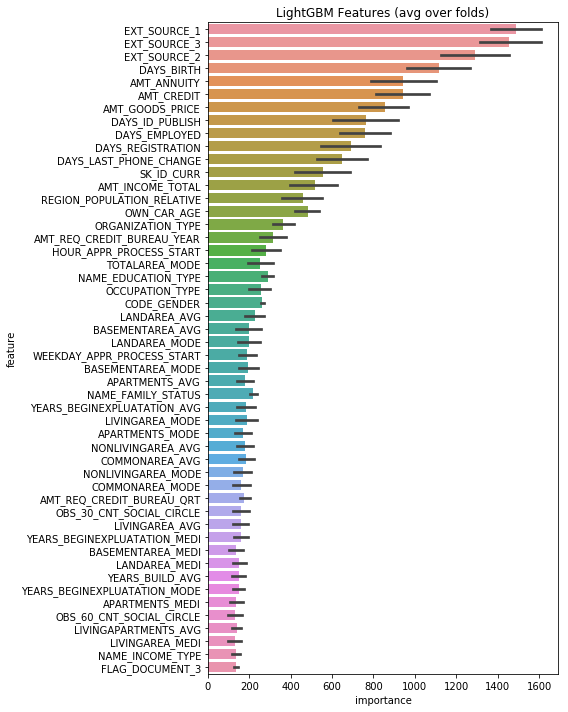

In [9]:
display_importances(feature_importance_df)

In [10]:
print(time.time() - st)

604.6368274688721
